# Mini projet 4: Prédiction de la structure secondaire

Le but de ce projet est d'implémenter l'algorithme GOR III et de faire quelques testes avec l'implémentation.

# Données

On nous fournit une grande collection de fichiers de protéines (qui portent l'extension _.DSSP_) et qui sont réferencés dans le _CATH\_info.txt_ avec la chaine à utiliser.

# Implémentation

In [3]:
VALID_AMINO = "ARNDCQEGHILKMFPSTWYVBZX"
VALID_STRUCTURE = "HETC"

Une structure de donnée pour représenter une séquence.

In [4]:
class Sequence():
    """
    ADT séquence qui représente une séquence d’acides aminés
    et tous les opérations qu’on peut exécuter sur une séquence.
    """
    def __init__(self, name, organism, id, sequence, structure):
        self.current = 0
        self.name = name
        self.organism = organism
        self.id = id
        self.sequence = sequence
        self.structure = structure
    
    def __repr__(self):
        return str(self.sequence)
    
    def __len__(self):
        return len(self.sequence)
    
    def __iter__(self):
        self.current = 0
        return self
    
    def next(self):
        if self.current > len(self.sequence):
            raise StopIteration
        else:
            self.current += 1
            return self.sequence[self.current - 1]
    
    def __getitem__(self, index):
        """
        @desc: Permet d'interpreter la classe comme une "String".
        
        @param{index}: Index de la lettre qu'on veut consulter.
        """
        return self.sequence[index]

La première étape est de savoir quels fichiers on va devoir utiliser pour récolter les données ainsi que quelles chaines chercher dans ces fichiers.

Pour ça on va utiliser le fichier _CATH_INFO.txt_ reçu avec l'énoncé qui contient des références vers des fichier _.dssp_ (parsé plus tard). Les 4 premières lettres est le nom du fichier et la dernière lettre est l'identifient de la chaine qu'on va utiliser pour créer les séquences. Ce que je fais ici c'est pour chaque fichier indiquer quelles identifiant il faut sauvegarder selon le fichier.

In [5]:
def indexFiles(indexFile):
    filesIndex = dict()
    with open(indexFile) as f:
        for seq in f:
            filename = seq[:4]
            x = seq[4]
            if filesIndex.get(filename):
                filesIndex[filename].append(x)
            else:
                filesIndex[filename] = list(x)
        
    return filesIndex    

Pour chaque fichier on sait pour quels identifiants on doit créer la séquence.

Ce qu'il faut savoir pour parser les fichiers _.pssd_ c'est que les informations sur les séquences commence à partir de la ligne 27 (j'utilise aussi quelques autres information sur le _nom_ et _l'organisme_ ligne 4 et 5), ces valeurs sont hardcodées au début du fichier car le format des fichiers _.dssp_ est toujours le même.

Pour chaque ligne des informations sur les séquences on a besoin de:

 * L'identifiant (3ème colonne) pour savoir si on a besoins de cette ligne.
 * L'acide aminé (4ème colonne) pour créer la séquence.
 * La structure secondaure (5ème colonne) pour créer la structure de la séquence.
 
Ces informations vont être récupérées dans l'algorithme qui suit et chaque séquence renvoyées une à une.

In [6]:
SYMBOLS = {
    "H": "H",
    "G": "H",
    "I": "H",
    "E": "E",
    "B": "E",
    "T": "T",
    "C": "C",
    "S": "C",
    " ": "C",
}

In [7]:
def parseDSSPFile(dsspFile, ids):
    """
    @desc: Cette méthode parse un sous fichier, ici un fichier .dssp

    @param{dsspFile}: 
    @param{name}: Nom du fichier .dssp à utiliser.
    @param{last}: Dernière lettre qui indique la chaine à utiliser dans le fichier DSSP.
    """

    # Les nombres ci dessous viennent du format des fichiers qu'on a reçu avec l'énoncé
    lineNumberForName = 4
    lineNumberForOrganism = 5
    lineNumberForSequenceBegin = 29
    # sequenceColumnEndIndex = 11
    # sequenceColumnIndex = 13
    # structureIndex = 16
    
    sequences = dict()
    structures = dict()
    for id in ids:
        sequences[id] = str()
        structures[id] = str()
        
    with open(dsspFile) as f:
        line = "" # pour sauvegarder la ligne
        
        # pour se placer a la bonne ligne
        for _ in range(lineNumberForName): line = f.readline()
        # le nom est la partie entre le : et le ;
        name = line.split(":")[1].strip().split(";")[0]

        # le nom de l'organisme est la partie entre le : et le ;
        line = f.readline()
        organism = line.split(":")[1].strip().split(";")[0]
        
        # pour se placer a la bonne ligne
        for _ in range(lineNumberForSequenceBegin - lineNumberForOrganism): line = f.readline()
         
        while line != "":
            chain = line[11]
            amino = line[13].upper()
            
            if chain in ids and SYMBOLS.get(amino):
                sequences[chain] += amino
                
                struct = line[16].upper()
                structures[chain] += SYMBOLS.get(struct)

            line = f.readline()

        for id in ids:
            yield Sequence(name, organism, id, sequences[id], structures[id])

In [8]:
result = []
a = indexFiles('./dataset/CATH_info.txt')
for key, item in a.items():
    result.extend([x for x in parseDSSPFile('./dataset/dssp/' + key + '.dssp', item)])
    
test = []
b = indexFiles('./dataset/CATH_info_test.txt')
for key, item in b.items():
    test.extend([x for x in parseDSSPFile('./dataset/dssp_test/' + key + '.dssp', item)])

# Implémentation de l'algorithme GOR3

In [101]:
from math import log, sqrt
import collections
from matplotlib import pyplot

class Gor3:
    """ 
    Cette classe représente l'algorithme Gor3 et permet d'obtenir son résultat
    """
    def __init__(self, sequences):
        self.sequences = sequences
        
        # Fréquence des structures
        self._fs = [0 for i in VALID_STRUCTURE]  
        # Fréqunce des pair (structure, AA)
        self._fsa = [[0 for i in VALID_AMINO] for j in VALID_STRUCTURE]
        # Fréquence du triplet (structure, AA, voisin)
        # Les voisins sont définis par une distance de 8 à gauche et à droite.
        self._fsaa = [[[0 for i in VALID_AMINO] for j in VALID_AMINO] for k in VALID_STRUCTURE]
        
        self._isa = [[0 for i in VALID_AMINO]for j in VALID_STRUCTURE]  # struc amino
        self._isaa = [[[0 for i in VALID_AMINO] for j in VALID_AMINO] for k in VALID_STRUCTURE]  # struc amino amino
        
        # ---- result storage----
        self._correctStructure = [0 for i in self.sequences]
        self._res_Q3 = [0 for i in self.sequences]
        self._res_Mcc = [[0 for j in VALID_STRUCTURE] for i in self.sequences]
        self._predictions = [None for i in self.sequences]
        
        self._make()

    def _computeF(self):
        """ 
        Parcourt les séquences des données reçu et remplis les matrices de fréquence 
        """
        for seq in self.sequences:
            for i in range(len(seq)):
                struct_aa = VALID_STRUCTURE.index(seq.structure[i])
                seq_aa = VALID_AMINO.index(seq[i])
                # on remplit la première matrice de fréquence
                self._fs[struct_aa] += 1
                
                # on remplit la deuxième matrice de fréquence
                self._fsa[struct_aa][seq_aa] += 1
                
                # les voisins
                for j in seq[max(0, i - 8):i] + seq[min(i + 1, len(seq)): min(i + 9, len(seq))]:
                #for j in range(-8, 9):  
                #    if j != 0 and (i + j) >= 0 and (i + j) < len(seq): # if not out of range
                        # on remplit la 3ème matrice de fréquence
                    self._fsaa[struct_aa][VALID_AMINO.index(j)][seq_aa] += 1

    def _computeI(self):
        """
        Parcourt les séquences et remplis les matrices de fréquence de score 
        """
        for i in range(len(self._isa)):
            for j in range(len(self._isa[0])):
                s = 0 # structure
                for k in range(len(VALID_STRUCTURE)):
                    if k != i:
                        s += self._fs[k]
                sa = 0 # structure amino
                for k in range(len(VALID_STRUCTURE)):
                    if k != i:
                        sa += self._fsa[k][j]
                if self._fs[i] == 0 or sa == 0 or self._fsa[i][j] == 0: # if log(0)
                    self._isa[i][j] = float("-inf")
                else:
                    # on remplit la première matrice de score
                    self._isa[i][j] = log(self._fsa[i][j] / sa) + log(s / self._fs[i])
                for k in range(len(self._isaa[0][0])):
                    saa = 0 # structure amino amino
                    for l in range(len(VALID_STRUCTURE)):
                        if l != i:
                            saa += self._fsaa[l][k][j]
                    if self._fsa[i][j] == 0 or saa == 0 or self._fsaa[i][k][j] == 0: # if log(0)
                        self._isaa[i][k][j] = float("-inf")
                    else:
                        # on remplit la deuxième matrice de score
                        self._isaa[i][k][j] = log(self._fsaa[i][k][j] / saa) + log(sa / self._fsa[i][j])

    def _findBestPrediction(self):
        """ 
        Trouve la meilleur prediction possible en fonction des matrice de score
        """
        for i, seq in enumerate(self.sequences):
            result = "" # structure secondaire
            for iSeq in range(len(seq)):
                # score pour chaque structure
                structScore = [0 for structure in VALID_STRUCTURE]
                for structure in range(len(VALID_STRUCTURE)):
                    structScore[structure] += self._isa[structure][VALID_AMINO.index(seq[iSeq])]
                    for k in range(-8, 9):  # les voisins
                        if k != 0 and iSeq + k >= 0 and iSeq + k < len(seq):
                                                        # structure
                                                        # amino 1
                                                        # amino 2
                            structScore[structure] += self._isaa[structure][VALID_AMINO.index(seq[iSeq + k])][VALID_AMINO.index(seq[iSeq])]
                # on ajoute le mieux
                result += VALID_STRUCTURE[structScore.index(max(structScore))]
            self._predictions[i] = result

    def _computeQ3(self):
        """ 
        Calcul en pourcent la quantité de structure prédite correct 
        """
        for iSeq, seq in enumerate(self.sequences):
            correctStructure = 0
            for amino in range(len(seq)):
                if self._predictions[iSeq][amino] == seq.structure[amino]:
                    correctStructure += 1
            self._correctStructure[iSeq] = correctStructure 
            self._res_Q3[iSeq] = correctStructure / len(seq) *100 # pour un res en pourcent

    def _computeMCC(self):
        """
        Calcul les Matthews correlation coefficient, la quantité des prédiction pour chaque état secondaire 
        """
        for i, seq in enumerate(self.sequences):
            MCC = [0 for i in range(len(VALID_STRUCTURE))]
            for j, structure in enumerate(VALID_STRUCTURE):
                # vp = vrai positif
                # vn = vrai négatif
                # fp = faux positif
                # fn = faux négatif
                VP = VN = FP = FN = 0
                for aminoIndex in range(len(seq)):
                    if self._predictions[i][aminoIndex] == seq.structure[aminoIndex]:
                        if self._predictions[i][aminoIndex] == structure:
                            VP += 1
                        else:
                            VN += 1
                    else:
                        if seq.structure[aminoIndex] == structure:
                            FN += 1
                        elif self._predictions[i][aminoIndex] == structure:
                            FP += 1
                            
                if (VP + FN) * (FP + VP) * (VN + FP) * (FN + VN) != 0: # si pas de division par zero
                    MCC[j] = ((VP * VN - FP * FN) / sqrt((VP + FN) * (FP + VP) * (VN + FP) * (FN + VN)))
                else:
                    MCC[j] = "ZeroDivision"
                self._res_Mcc[i][j] = MCC[j]
                
    def _make(self):
        """
        Appel les différentes méthodes permettant d'executer GOR3
        """
        self._computeF()
        self._computeI()
        self._findBestPrediction()
        self._computeQ3()
        self._computeMCC()
        
    def plot_single(self):
        """
        """
        for i, seq in enumerate(self.sequences):
            for j, structure in enumerate(VALID_STRUCTURE):
                VP = VN = FP = FN = 0
                
                P = 0
                for aminoIndex in range(len(seq)):
                    if self._predictions[i][aminoIndex] == seq.structure[aminoIndex]:
                        if self._predictions[i][aminoIndex] == structure:
                            P += 1
                N = len(seq) - P
                if (P == 0) or (N == 0):
                    continue
                
                curve = []
                for aminoIndex in range(len(seq)):
                    if self._predictions[i][aminoIndex] == seq.structure[aminoIndex]:
                        if self._predictions[i][aminoIndex] == structure:
                            VP += 1
                        else:
                            VN += 1
                    else:
                        if seq.structure[aminoIndex] == structure:
                            FN += 1
                        elif self._predictions[i][aminoIndex] == structure:
                            FP += 1
                            
                            
                    curve.append(((FP)/N, (VP)/P))
                pyplot.plot(*zip(*curve), label="Structure %s of %i" % (structure, i))
                        
        pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        pyplot.show()

    def plot(self):
        """
        """
        curves = dict()
        for struct in VALID_STRUCTURE:
            curves[struct] = list()
                
        for i, seq in enumerate(self.sequences):
            for j, structure in enumerate(VALID_STRUCTURE):
                # vp = vrai positif
                # vn = vrai négatif
                # fp = faux positif
                # fn = faux négatif
                VP = VN = FP = FN = 0
                
                P = 0
                for aminoIndex in range(len(seq)):
                    if self._predictions[i][aminoIndex] == seq.structure[aminoIndex]:
                        if self._predictions[i][aminoIndex] == structure:
                            P += 1
                N = len(seq) - P
                if (P == 0) or (N == 0):
                    continue
                
                curve = []
                for aminoIndex in range(len(seq)):
                    if self._predictions[i][aminoIndex] == seq.structure[aminoIndex]:
                        if self._predictions[i][aminoIndex] == structure:
                            VP += 1
                        else:
                            VN += 1
                    else:
                        if seq.structure[aminoIndex] == structure:
                            FN += 1
                        elif self._predictions[i][aminoIndex] == structure:
                            FP += 1
                            
                            
                    curves[structure].append((FP/N, VP/P))
                        
        for structure in VALID_STRUCTURE:
            curves[structure].sort(key=lambda x: x[0])
            pyplot.plot(*zip(*curves[structure]), label="Structure " + structure)
        pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        pyplot.show()
        
    def plot_all_in_single(self):
        """
        """
        for i, seq in enumerate(self.sequences):
            curve = []
            VP = VN = FP = FN = 0
            P = self._correctStructure[i]
            N = len(seq) - P
            if (P == 0) or (N == 0):
                continue
 
            for j, structure in enumerate(VALID_STRUCTURE):
                for aminoIndex in range(len(seq)):
                    if self._predictions[i][aminoIndex] == seq.structure[aminoIndex]:
                        if self._predictions[i][aminoIndex] == structure:
                            VP += 1
                        else:
                            VN += 1
                    else:
                        if seq.structure[aminoIndex] == structure:
                            FN += 1
                        elif self._predictions[i][aminoIndex] == structure:
                            FP += 1
                            
                            
                    curve.append(((FP)/N, (VP)/P))
            pyplot.plot(*zip(*curve), label="Sequence %i" % (i))
                        
        pyplot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        pyplot.show()

    def __str__(self):
        res = "------ Gor3 Result -------" + "\n"
        for i, seq in enumerate(self.sequences):
            res += "---------------------------" + "\n"
            res += "Prediction :" + self._predictions[i] + "\n"
            res += "Real       :" + seq.structure + "\n"
            res += "\n"
            res += "Q3 = " + str(self._res_Q3[i]) + "%\n"
            for j, mcc in enumerate(self._res_Mcc[i]):
                res += "MCC " + str(VALID_STRUCTURE[j]) + " = "
                res += str(mcc) + "\n"

        res += "-----------\n"
        res += "Global result" + "\n"
        res += "Q3 global : " + str(sum(self._res_Q3) / len(self._res_Q3)) + "%\n"

        res += "MCC H global : " + str(sum((row[0] / len(self._res_Mcc) if type(row[0])==float else 0) for row in self._res_Mcc))  + "\n"
        res += "MCC E global : " + str(sum((row[1] / len(self._res_Mcc) if type(row[1])==float else 0) for row in self._res_Mcc))  + "\n"
        res += "MCC C global : " + str(sum((row[3] / len(self._res_Mcc) if type(row[3])==float else 0) for row in self._res_Mcc))  + "\n"
        res += "MCC T global : " + str(sum((row[2] / len(self._res_Mcc) if type(row[2])==float else 0) for row in self._res_Mcc))  + "\n"
        res += "\n"
        return res

## Discussion

L'algorithme GOR3 consiste en plusieurs étape:

1. Calculer les fréquences pour:
    * Les structures ($f_S$)
    * Les paires de structure et acide aminé ($f_{S, R}$)
    * Les triplets de structure, acide aminé et leurs voisins ($f_{S, Rm, R}$)
2. Utiliser ces fréquences pour faire les prédictions.
3. Calculer Q3 et MCC.
4. Visualiser les prédictions à l'aide des courbes ROC .

La formule pour calculer les prédictions est la suivante:

$$\
I(\Delta S;R) = I(S; R) - I(n - S; R) = log(\frac{f_{S, R}}{f_{n-S, R}}) + log(\frac{f_{n-S}}{f_S}) \\
I(\Delta S_j; R_{j+m} | R_j) = log(\frac{f_{S_j, R_{j+m}, R_j}}{f_{n-S_j, R_{j+m}, R_j}}) + log(\frac{f_{n-S_j, R_j}}{f_{s_j}, R_j}) \\
I(\Delta S_j; R_1, ..., R_n) = I(\Delta S_j; R_j) + \sum_{m,m \neq 0} I(\Delta S_j; R_{j+m}|R_j)\
$$

Quant à l'analyse de la qualité des prédictions on utilise les équations suivante.

$$\
Q3= \frac{nombre de prédiction correct}{nombre de résidu}\\
MCC = \frac{TP x TN - FP x FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}\
$$



# Résultat

Voici les résultats obtenus avec les algorithme implémenté précedemment.

In [102]:
g = Gor3(result)

In [103]:
print(g)

------ Gor3 Result -------
---------------------------
Prediction :EEEETEEEEEETEEETEETEEHTEEEHHTEETTHEEEETTTEEETTTETTETEEEEETEEEEEEEETETTEETTTEEEETTEEETTEEETTETTETTTTEEHETETTHEEETTETTTHEETETTEETEHTETETEEHEETTTTETEETTTTETEETTTETE
Real       :EECCHCEEECETCCCCCTTCEECEEECCCEEEEECCEEETTCECHCTTCCEETEEEECECEEEEEEHTTCCCCCEEEECCEEEECCEEECCCCEEEECCEEEEEEEEEEEETTCEEEEEEEEEEEEEEETCCCCEEEEEEETTEEECCTTTEEEECCCCTC

Q3 = 45.962732919254655%
MCC H = -0.06499762281559937
MCC E = 0.011625654161266928
MCC T = 0.23521963352284342
MCC C = ZeroDivision
---------------------------
Prediction :HTETHTHEETHHHEHETETETTTTTETEHEEETTHHTHEEHHTHHEETHTHHEEEETTEETEEEETEEEETTTEEHHHETEETHTHHHTHHEHHTETTETTTTTTETHETTEEEHET
Real       :CCETCCECCEEETCTHHTTECCCCHHHEEHHTTTTTTCCHHHTCTECCCCHHHHHHTCCCTTHTTCEEEEHCHHHHHHHTEEEECCTCTHHHHHEEECCCCTTHTCHHHCCHHHCHC

Q3 = 30.76923076923077%
MCC H = -0.12944203892839232
MCC E = -0.016700439075497436
MCC T = -0.014981613860346242
MCC C = ZeroDivision
---------------------------
Prediction :E

## ROC

J'ai essayé de modéliser plusieurs manière mes résultats. Les modélisations sont visible quand il y a peu de séquence mais illisible pour les donnée avec beaucoup de donnée. C'est pourquoi je ne montre que les résultat sur les données test.

In [106]:
%matplotlib inline

La modélisation ci dessous présente l'évolution de chaque structure toutes séquences confondues. Cette modélisation n'est pas très interessante nous dit pas grand chose sur l'évolution. 

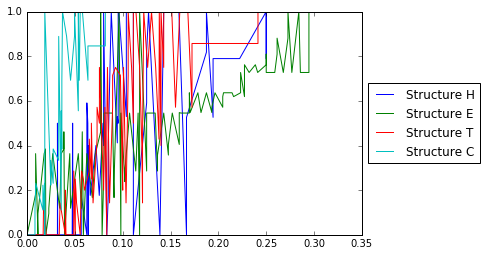

In [107]:
t = Gor3(test)
t.plot()

La modélisation ici présente l'évolution de chaque structure pour chaque séquence individuelle. Elle est interessante mais peu lisible dés qu'il y a plusieurs séquence. Ça serait plus intéressant de voir une telle modélisation en choisissant la séquence sur laquelle on veut executer la modélisation avant.

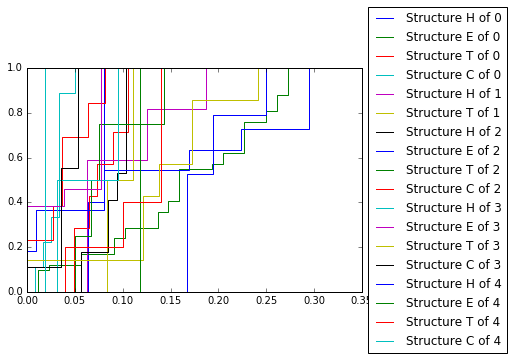

In [108]:
t.plot_single()

Ici je montre l'évolution de chaque séquence séparemment sans prendre compte des structures. Celle-ci nous donne le plus d'information sur l'évolutoin on peut rapidement voir quels sont les séquences qui évoluent le plus vite, ...

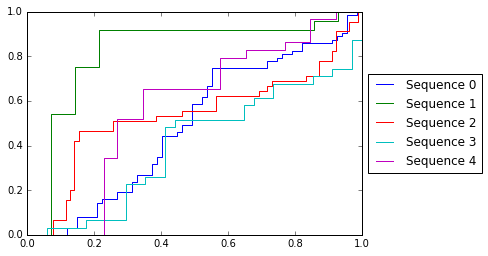

In [109]:
t.plot_all_in_single()